In [1]:
import sys
import os
import glob
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import load_participant_list, get_betamap_paths

# Parameters

In [2]:
statistic = 'z_score'
multiple_comp_corr = 'fdr'
alpha = 0.05
run = 'test'
first_level_dir = '/home/ubuntu/data/learning-habits/bids_dataset/derivatives/nilearn/rsa_20250219'

# First level parameters

In [3]:
# Find the first JSON file
json_file_path = glob.glob(os.path.join(first_level_dir, '**', '*_params.json'), recursive=True)[0]

# Load and print the JSON file contents
with open(json_file_path, 'r') as file:
    json_data = json.load(file)
    for key, value in json_data.items():
        print(f"{key}: {value}")


model_name: rsa
tr: 2.33384
hrf_model: spm
noise_model: ar1
smoothing_fwhm: 5
high_pass: 0.01
motion_type: basic
fd_thresh: 0.5
std_dvars_thresh: 2
scrub: dummies
include_physio: True
brain_mask: True
duration: all
exclusion_threshold: 0.2


# Load First level data

In [4]:
base_dir = '/home/ubuntu/data/learning-habits'
sub_ids = load_participant_list(base_dir)

In [5]:
stimuli = [1, 2, 3, 4, 5, 6, 7, 8]

In [16]:
beta_maps = {f"stim_{stim}": get_betamap_paths(sub_ids, first_level_dir, run, f"sub-{{sub_id}}_run-{{run}}_betamap_first_stim_presentation_{stim}.nii.gz")[0] for stim in stimuli}

## Load masks

In [18]:
mask_dir = '/home/ubuntu/data/learning-habits/masks'
vmpfc_mask_path = os.path.join(mask_dir, 'vmpfc_mask.nii.gz')
striatum_mask_path = os.path.join(mask_dir, 'striatum_mask.nii.gz')
putamen_mask_path = os.path.join(mask_dir, 'putamen_mask.nii.gz')
parietal_mask_path = os.path.join(mask_dir, 'parietal_mask.nii.gz')

# Stim 8 vs Stim 1

In [32]:
all_maps = beta_maps['stim_1'] + beta_maps['stim_2']+ beta_maps['stim_3']+ beta_maps['stim_6']+ beta_maps['stim_7']+ beta_maps['stim_8']
n_subs = len(beta_maps['stim_1'])
assert len(all_maps) == n_subs * 6

In [33]:
design_matrix = pd.DataFrame({
    'stim_low': [1]*n_subs*3 + [0]*n_subs*3,
    'stim_high': [0]*n_subs*3 + [1]*n_subs*3
})

second_level_model = SecondLevelModel().fit(
    all_maps,
    design_matrix=design_matrix
)

# Compute stim_8 - stim_1
z_map = second_level_model.compute_contrast([ -1, 1 ])  # means stim_8 minus stim_1

## Whole brain

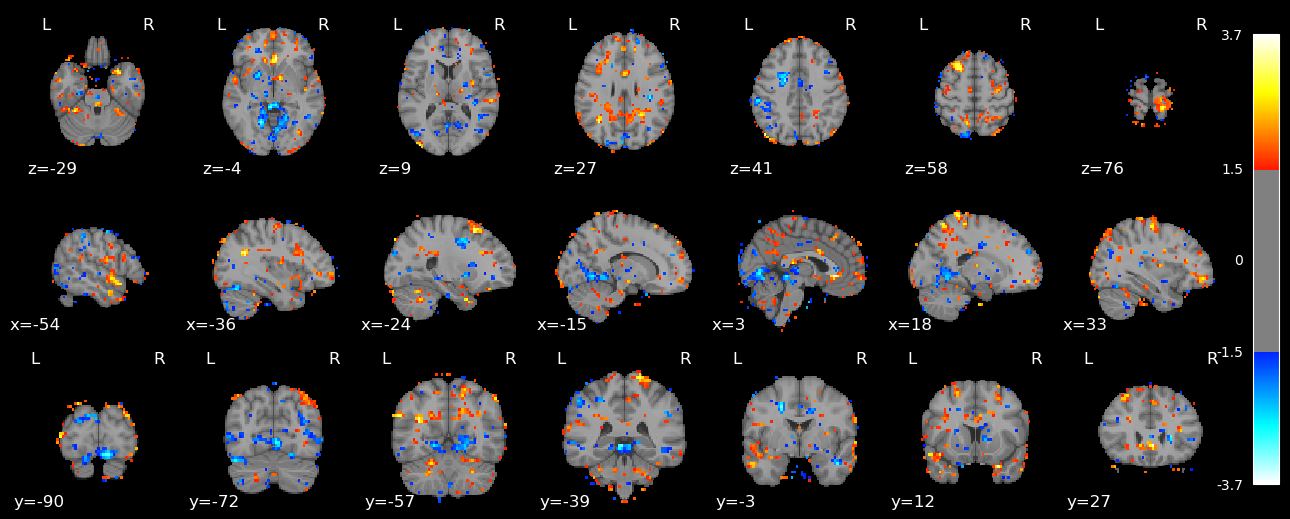

In [34]:
plot_stat_map(z_map,threshold=1.5, black_bg=True, display_mode='mosaic', title='')

### Correct for multiple comparisons

In [35]:
thresholded_zmap, threshold = threshold_stats_img(z_map, alpha=alpha, height_control='fdr')#, cluster_threshold=30)
print(f"RL whole brain Bonferroni threshold: {threshold:.3f}")

RL whole brain Bonferroni threshold: inf


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.6895084608939612. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


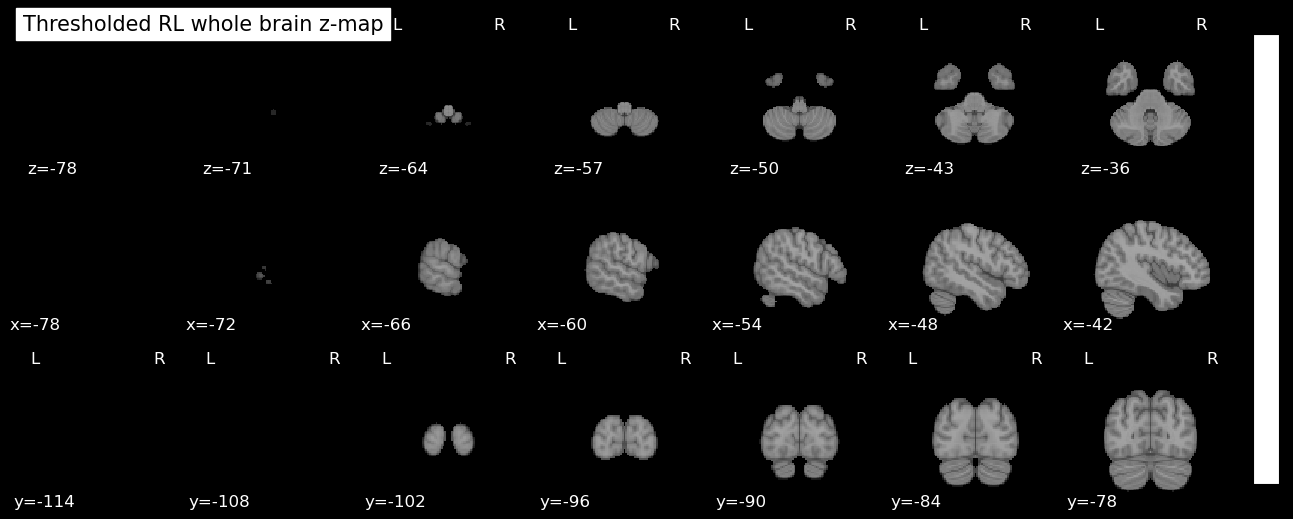

In [14]:
plot_stat_map(RL_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL whole brain z-map')

## ROIs for Q-values: VMPFC

In [15]:
vmpfc_mask = image.load_img(vmpfc_mask_path)
vmpfc_mask = image.resample_to_img(vmpfc_mask, RL_WB_zmap, interpolation='nearest')
vmpfc_masker = NiftiMasker(mask_img=vmpfc_mask)

In [16]:
vmpfc_second_level = SecondLevelModel(mask_img=vmpfc_masker).fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [17]:
RL_vmpfc_zmap = vmpfc_second_level.compute_contrast(output_type=statistic)

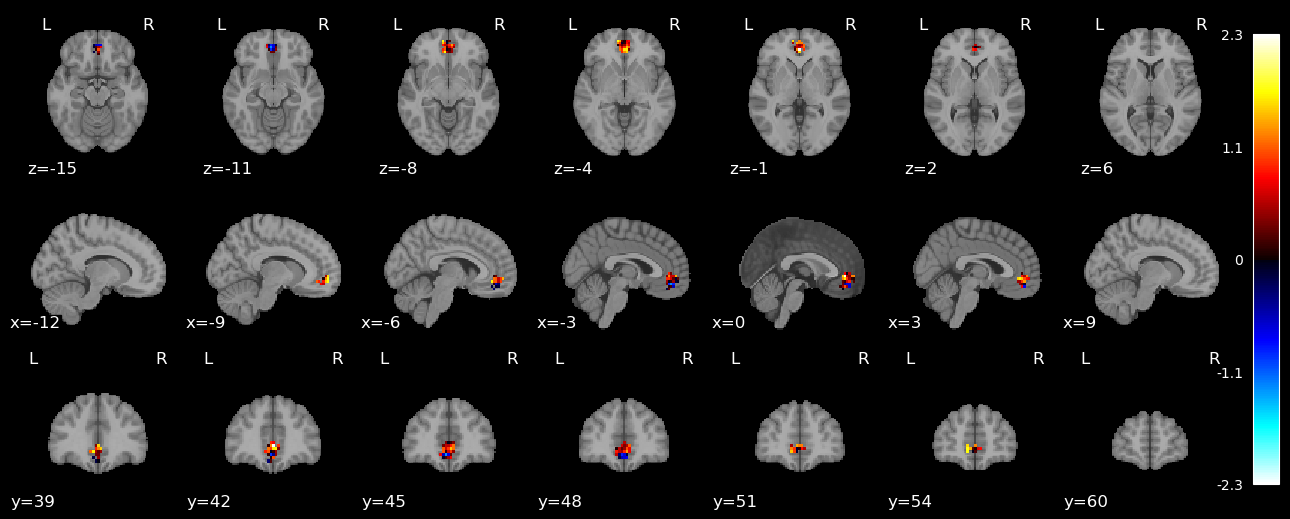

In [18]:
plot_stat_map(RL_vmpfc_zmap, black_bg=True, display_mode='mosaic', title='')

In [19]:
RL_vmpfc_thresholded_zmap, RL_vmpfc_threshold = threshold_stats_img(RL_vmpfc_zmap, alpha=alpha, height_control='fdr')

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.2681186771507855. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


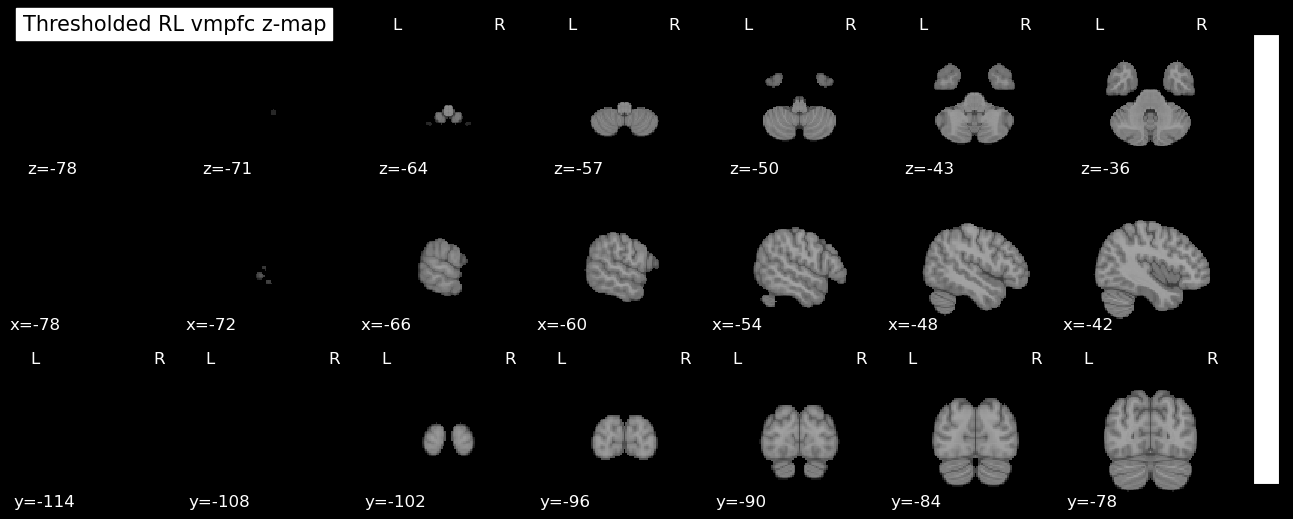

In [20]:
plot_stat_map(RL_vmpfc_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL vmpfc z-map')

In [21]:
vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)
vmpfc_table

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.2681186771507855. But, you have given threshold=inf.
  stat_img = threshold_img(
/tmp/ipykernel_227680/1167065061.py:1: UserWarning: Attention: No clusters with stat higher than inf
  vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)
/tmp/ipykernel_227680/1167065061.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  vmpfc_table = get_clusters_table(RL_vmpfc_zmap, stat_threshold=RL_vmpfc_threshold, two_sided=True)


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


## ROIs for Q-values: Striatum

In [22]:
striatum_mask = image.load_img(striatum_mask_path)
striatum_mask = image.resample_to_img(striatum_mask, RL_WB_zmap, interpolation='nearest')
striatum_masker = NiftiMasker(mask_img=striatum_mask)

In [23]:
striatum_second_level = SecondLevelModel(mask_img=striatum_masker)
striatum_second_level = striatum_second_level.fit(contrast_modulator_RL_imgs, design_matrix=X_RL)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [24]:
RL_striatum_zmap = striatum_second_level.compute_contrast(output_type=statistic)

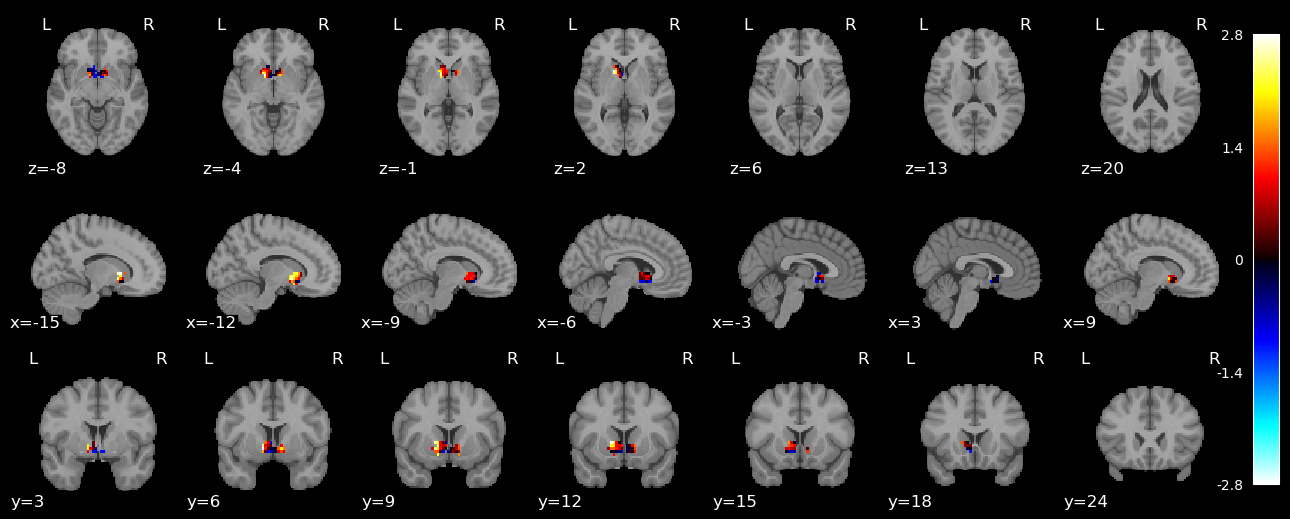

In [25]:
plot_stat_map(RL_striatum_zmap, black_bg=True, display_mode='mosaic', title='')

In [26]:
RL_striatum_thresholded_zmap, RL_striatum_threshold = threshold_stats_img(RL_striatum_zmap, alpha=alpha, height_control=multiple_comp_corr)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.820527048107725. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


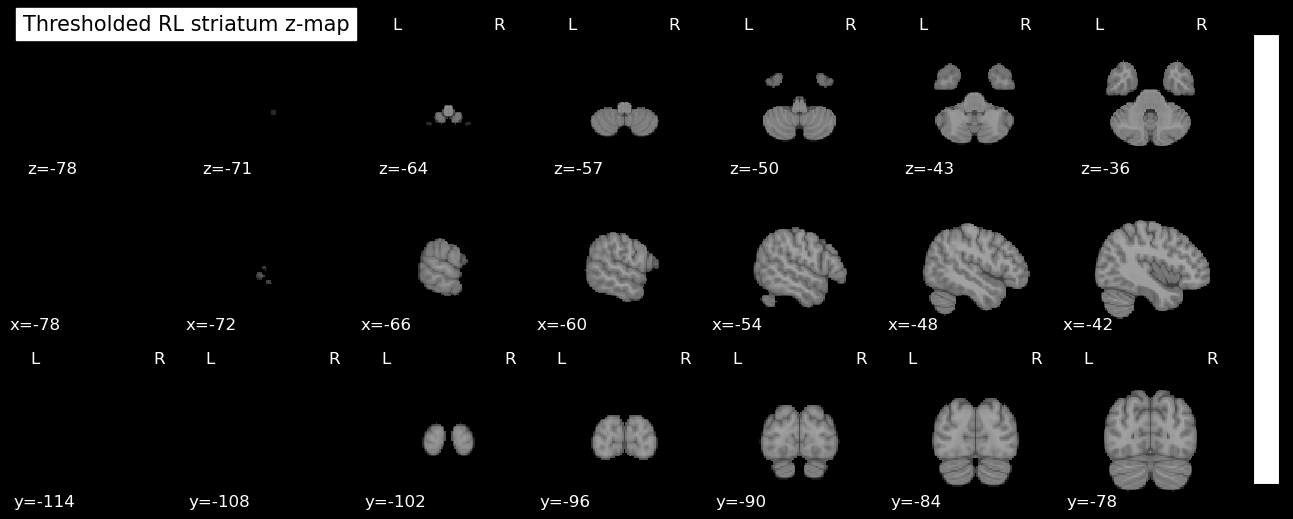

In [27]:
plot_stat_map(RL_striatum_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded RL striatum z-map')

In [28]:
striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.820527048107725. But, you have given threshold=inf.
  stat_img = threshold_img(
/tmp/ipykernel_227680/2531939775.py:1: UserWarning: Attention: No clusters with stat higher than inf
  striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)
/tmp/ipykernel_227680/2531939775.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  striatum_table = get_clusters_table(RL_striatum_zmap, stat_threshold=RL_striatum_threshold, two_sided=True)


In [29]:
striatum_table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


# H-value modulation

In [30]:
X_CK = pd.DataFrame([1] * len(contrast_modulator_CK_imgs), columns=['CK_value'])

In [31]:
second_level_model_CK = SecondLevelModel()
second_level_model_CK = second_level_model_CK.fit(contrast_modulator_CK_imgs, design_matrix=X_RL)

In [32]:
CK_WB_zmap = second_level_model_CK.compute_contrast(output_type=statistic)

## Whole brain

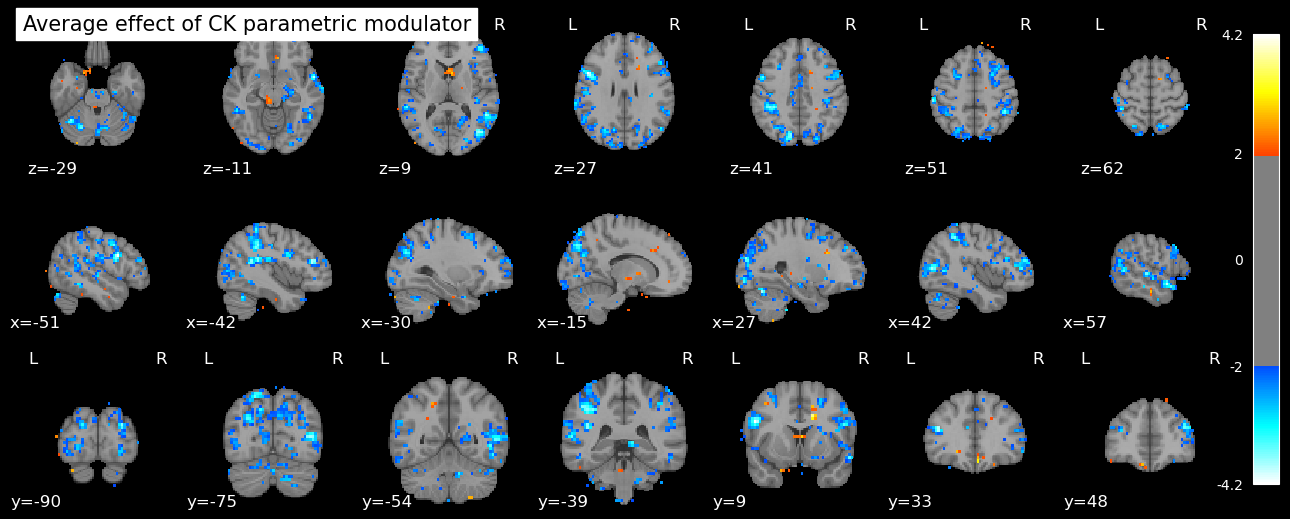

In [33]:
plot_stat_map(CK_WB_zmap, threshold=2, black_bg=True, display_mode='mosaic', title='Average effect of CK parametric modulator')

### Correct for multiple comparisons

In [34]:
CK_WB_thresholded_zmap, CK_WB_threshold = threshold_stats_img(CK_WB_zmap, alpha=alpha, height_control='fdr')#, cluster_threshold=1)
print(f"CK whole brain Bonferroni threshold: {CK_WB_threshold:.3f}")

CK whole brain Bonferroni threshold: inf


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.230517166105333. But, you have given threshold=inf.
  stat_img = threshold_img(


In [35]:
np.corrcoef(CK_WB_zmap.get_fdata().flatten(), RL_WB_zmap.get_fdata().flatten())

array([[ 1.        , -0.17947595],
       [-0.17947595,  1.        ]])

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


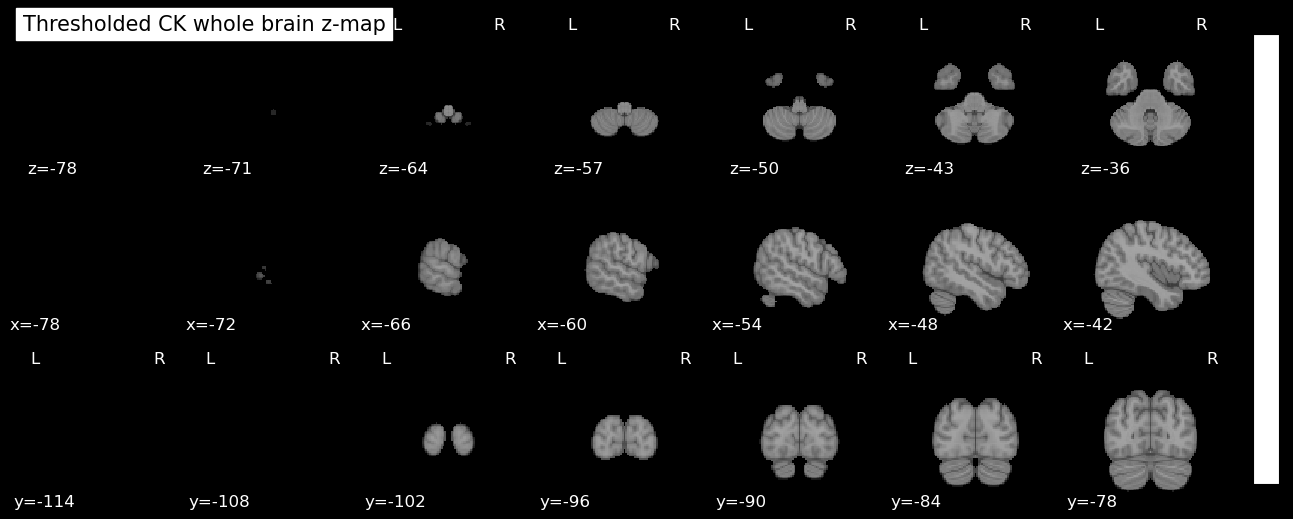

In [36]:
plot_stat_map(CK_WB_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK whole brain z-map')

## ROIs for H-values: putamen

In [37]:
putamen_mask = image.load_img(putamen_mask_path)
putamen_mask = image.resample_to_img(putamen_mask, RL_WB_zmap, interpolation='nearest')
putamen_masker = NiftiMasker(mask_img=putamen_mask)

In [38]:
putamen_second_level = SecondLevelModel(mask_img=putamen_masker)
putamen_second_level = putamen_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [39]:
CK_putamen_zmap = putamen_second_level.compute_contrast(output_type=statistic)

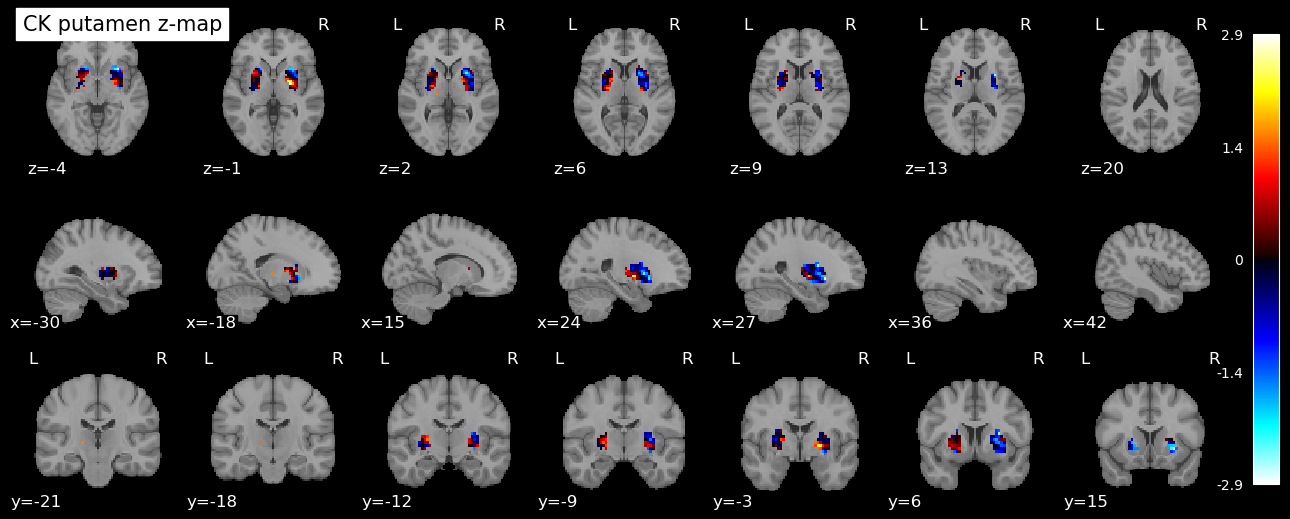

In [40]:
plot_stat_map(CK_putamen_zmap, black_bg=True, display_mode='mosaic', title='CK putamen z-map')

In [41]:
CK_putamen_thresholded_zmap, CK_putamen_threshold = threshold_stats_img(CK_putamen_zmap, alpha=alpha, height_control='fdr')

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 2.870377659819993. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


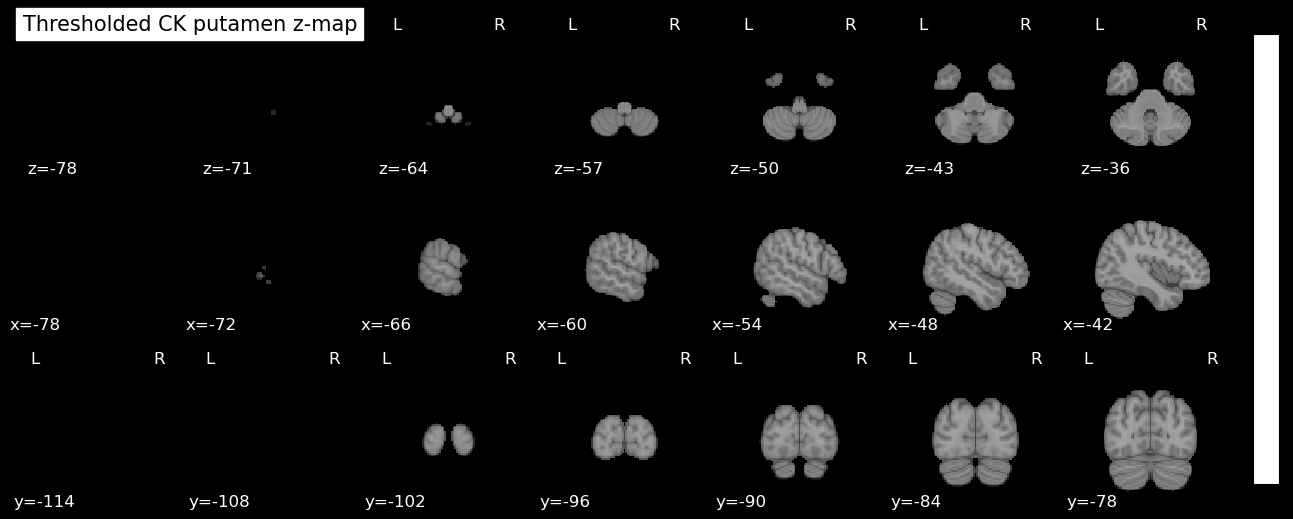

In [42]:
plot_stat_map(CK_putamen_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK putamen z-map')

In [43]:
putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
putamen_table

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/reporting/get_clusters_table.py:302: UserWarning: The given float value must not exceed 2.870377659819993. But, you have given threshold=inf.
  stat_img = threshold_img(
/tmp/ipykernel_227680/2590643497.py:1: UserWarning: Attention: No clusters with stat higher than inf
  putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)
/tmp/ipykernel_227680/2590643497.py:1: UserWarning: Attention: No clusters with stat lower than -inf
  putamen_table = get_clusters_table(CK_putamen_zmap, stat_threshold=CK_putamen_threshold, two_sided=True)


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


## ROIs for H-values: parietal cortex

In [44]:
parietal_mask = image.load_img(parietal_mask_path)
parietal_mask = image.resample_to_img(parietal_mask, RL_WB_zmap, interpolation='nearest')
parietal_masker = NiftiMasker(mask_img=parietal_mask)

In [45]:
parietal_second_level = SecondLevelModel(mask_img=parietal_masker)
parietal_second_level = parietal_second_level.fit(contrast_modulator_CK_imgs, design_matrix=X_CK)

/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")
/home/ubuntu/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/second_level/second_level.py:514: UserWarning: Parameter memory_level of the masker overridden
  warn(f"Parameter {param_name} of the masker overridden")


In [46]:
CK_parietal_zmap = parietal_second_level.compute_contrast(output_type=statistic)

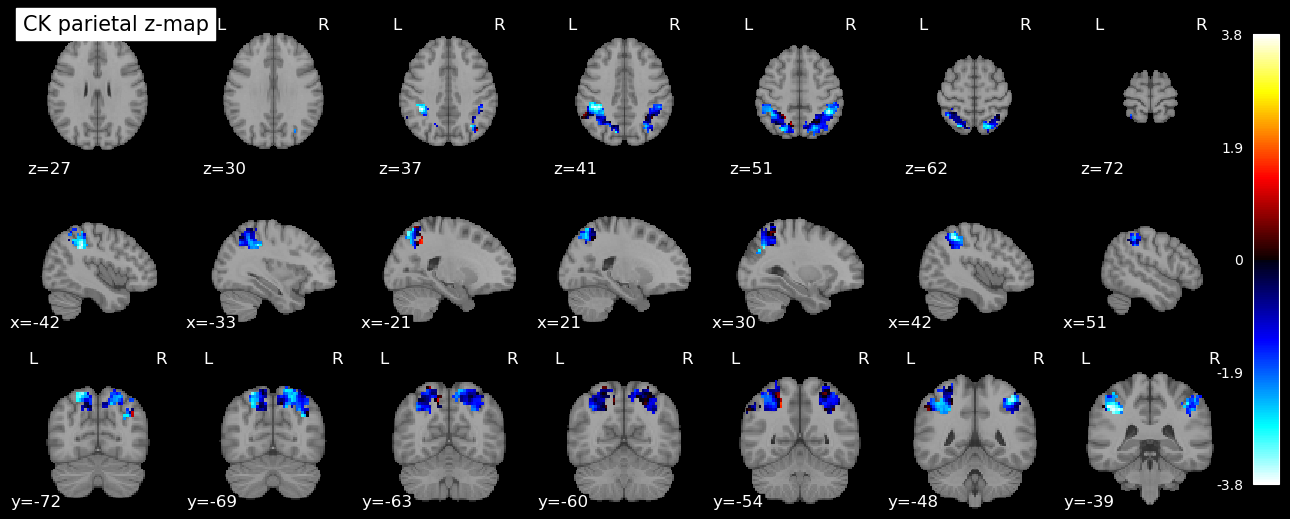

In [47]:
plot_stat_map(CK_parietal_zmap, black_bg=True, display_mode='mosaic', title='CK parietal z-map')

In [48]:
CK_parietal_thresholded_zmap, CK_parietal_threshold = threshold_stats_img(CK_parietal_zmap, alpha=alpha, height_control=multiple_comp_corr)

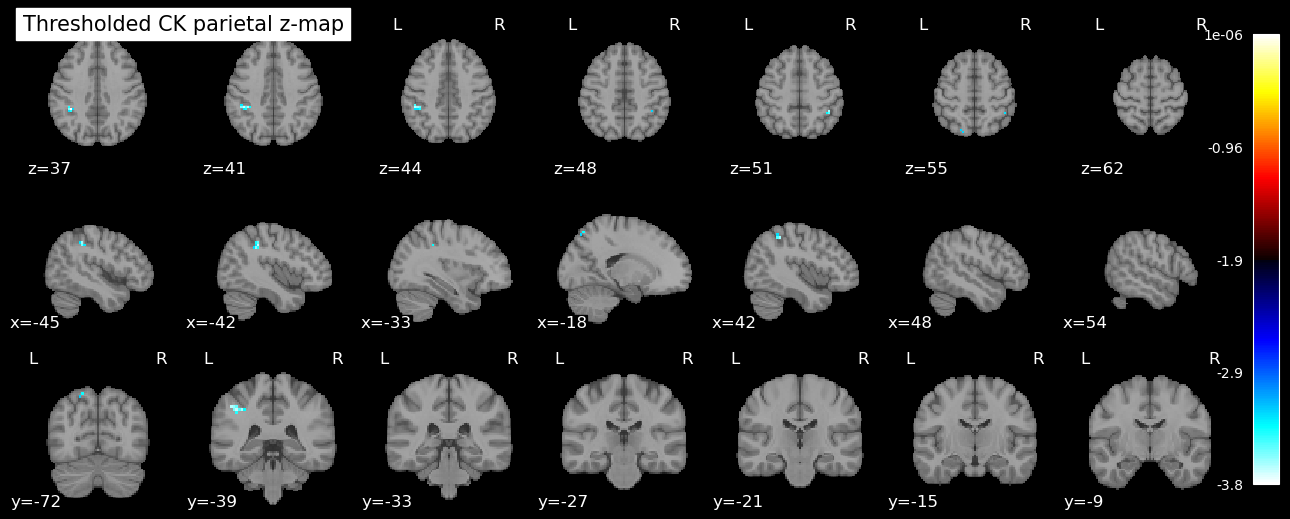

In [49]:
plot_stat_map(CK_parietal_thresholded_zmap, black_bg=True, display_mode='mosaic', title='Thresholded CK parietal z-map')

In [50]:
parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)

/tmp/ipykernel_227680/2125408686.py:1: UserWarning: Attention: No clusters with stat higher than 3.2223003900819793
  parietal_table = get_clusters_table(CK_parietal_zmap, stat_threshold=CK_parietal_threshold, two_sided=True)


# Design matrices

In [51]:
DM_paths , _ = get_betamap_paths(sub_ids, first_level_dir, run, "sub-{sub_id}_run-{run}_design_matrix.csv")

DMs = [pd.read_csv(path) for path in DM_paths]

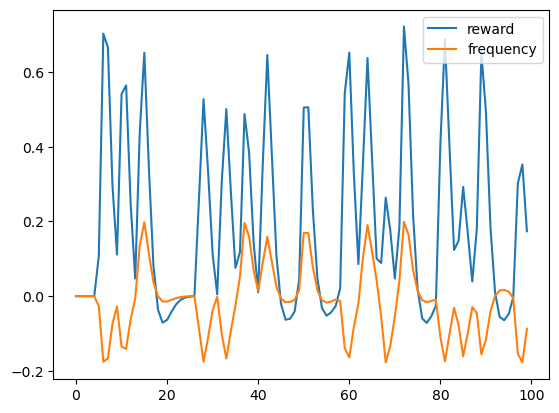

In [52]:
plt.plot(DMs[1].first_stim_reward[:100], label='reward')
plt.plot(DMs[1].first_stim_frequ[:100], label='frequency')
plt.legend()

In [53]:
DMs[1].head(40)

,first_stim_presentation_exclude,first_stim_reward,first_stim_frequ,first_stim_presentation_include,iti,purple_frame,response,second_stim_presentation,csf,rot_x,...,physio12,physio13,physio14,physio15,physio16,physio17,physio18,scrub_vol_472,scrub_vol_473,constant
0,1.193302e-03,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000001,7.188936,0.002965,...,0.401526,0.852049,-0.523462,-0.875941,-0.482419,-0.711709,-0.702475,0.0,0.0,1.0
1,9.861827e-02,0.000000,0.000000,0.000000,6.158285e-10,0.031471,0.002841,0.028829,18.272220,0.003141,...,0.702976,-0.999970,0.007766,0.844980,-0.534797,0.531512,0.847051,0.0,0.0,1.0
2,1.641943e-01,0.000000,0.000000,0.000000,4.382822e-02,0.325648,0.009661,0.078270,17.816200,0.002965,...,-0.634521,0.382886,0.923795,-0.602634,0.798018,0.057826,-0.998327,0.0,0.0,1.0
3,9.579357e-02,0.000000,0.000000,0.000000,4.083274e-01,0.414833,0.007293,0.054830,18.821341,0.003152,...,0.824438,-0.970118,0.242634,0.128624,-0.991693,-0.968535,-0.248878,0.0,0.0,1.0
4,2.964461e-02,0.000000,0.000000,0.000000,8.517461e-01,0.220507,0.002816,0.020053,28.971646,0.002965,...,0.200927,0.963840,0.266480,0.589708,0.807617,0.692946,0.720990,0.0,0.0,1.0
5,-2.836190e-03,0.106456,-0.026614,0.026614,1.054309e+00,0.060512,0.000406,0.002976,5.674450,0.003484,...,0.843262,0.727154,0.686475,-0.857111,0.515131,0.606237,-0.795284,0.0,0.0,1.0
6,-1.399396e-02,0.703037,-0.175759,0.175759,7.852558e-01,0.117843,0.005800,0.044027,11.928074,0.002517,...,-0.933156,-0.848882,0.528582,0.026763,-0.999642,-0.953777,-0.300514,0.0,0.0,1.0
7,-1.385753e-02,0.666112,-0.166528,0.166528,4.647992e-01,0.390614,0.008679,0.058475,9.011046,0.003087,...,-0.041850,0.998443,-0.055787,0.698881,-0.715238,0.718567,-0.695458,0.0,0.0,1.0
8,-9.417862e-03,0.296881,-0.074220,0.074220,6.266951e-01,0.313385,0.004596,0.029120,4.990806,0.003569,...,-0.993497,-0.625478,-0.780242,-0.861066,-0.508494,0.085802,-0.996312,0.0,0.0,1.0
9,-5.052917e-03,0.111406,-0.027852,0.027852,8.650307e-01,0.120024,0.001163,0.007053,25.852642,0.003392,...,-0.563473,0.698061,0.716039,0.733296,-0.679909,0.411502,-0.911409,0.0,0.0,1.0
